# Neural Language Modeling
### DS-GS 1008 Lab 04
Prepared by Sean Welleck

In [ ]:
%pylab inline
import torch
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [ ]:
!pip install transformers tokenizers datasets

     |████████████████████████████████| 1.1MB 3.3MB/s 
     |████████████████████████████████| 3.0MB 36.8MB/s 
     |████████████████████████████████| 1.8MB 45.3MB/s 
     |████████████████████████████████| 890kB 46.9MB/s 
     |████████████████████████████████| 1.1MB 39.8MB/s 
     |████████████████████████████████| 17.3MB 231kB/s 
     |████████████████████████████████| 245kB 48.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=0453d049636c6e8fc19439ebe80133a7d7a809a62f01e1aac8558a1bbe931982
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
ERROR: transformers 3.3.0 has requirement tokenizers==0.8.1.rc2, but you'll have tokenizers 0.8.1 which is incompatible.
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1


In [ ]:
!wget -O materials.zip https://nyu.box.com/shared/static/emc08shlzc41p4v5fk8c7idmzwz3pu8p.zip
!unzip materials.zip

--2020-09-28 23:57:16--  https://nyu.box.com/shared/static/emc08shlzc41p4v5fk8c7idmzwz3pu8p.zip
Resolving nyu.box.com (nyu.box.com)... 107.152.29.197
Connecting to nyu.box.com (nyu.box.com)|107.152.29.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/emc08shlzc41p4v5fk8c7idmzwz3pu8p.zip [following]
--2020-09-28 23:57:16--  https://nyu.box.com/public/static/emc08shlzc41p4v5fk8c7idmzwz3pu8p.zip
Reusing existing connection to nyu.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://nyu.app.box.com/public/static/emc08shlzc41p4v5fk8c7idmzwz3pu8p.zip [following]
--2020-09-28 23:57:16--  https://nyu.app.box.com/public/static/emc08shlzc41p4v5fk8c7idmzwz3pu8p.zip
Resolving nyu.app.box.com (nyu.app.box.com)... 107.152.29.201
Connecting to nyu.app.box.com (nyu.app.box.com)|107.152.29.201|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.com/d/1/b

# Language modeling

Overview of what we'll see how to do in practice:

### Model
- Autoregressive language modeling
$$p_\theta(\mathbf{y})=\prod_{t=1}^T\underbrace{p_{\theta}(y_t\mid\mathbf{y}_{<t})}_{\text{neural network}}$$
    - Recurrent neural network
    - Transformer
    
### Learning
- Maximum likelihood
$$\underset{\theta}{\arg\max} \sum_{\mathbf{y}\in \mathcal{D}}\log p_{\theta}(\mathbf{y})$$

### Inference
- Decoding (for generation)
    - Ancestral sampling
$$\hat{\mathbf{y}}_{k+1:T}\sim \text{sample}(p_{\theta}, \mathbf{y}_{1:k})$$

# I. Recurrent language model

## 0. Data

$\mathcal{D}=\{\mathbf{y}^{(i)}\}$

We'll use sequences $\mathbf{y}$ derived from the `bookcorpus`.
- [Dataset info](https://huggingface.co/nlp/viewer/?dataset=bookcorpus)
- Preprocessing: see `prepare_data.py` if curious

In [ ]:
import pickle
from tokenizers import Tokenizer

data_file = './tokenized_bookcorpus_sentences=3_n=145559_minlen=10_maxlen=100.pkl'

dataset = pickle.load(open(data_file, 'rb'))
train = dataset['train']
valid = dataset['valid']
tokenizer = dataset['tokenizer']


print("Dataset size\n\t%d (train)\n\t%d (valid)" % (len(train), len(valid)))
print("Vocab size\n\t%d" % (tokenizer.get_vocab_size()))
text = dataset['tokenizer'].decode(dataset['train'][0])
print("Example:\n\t%s" % text)

Dataset size
	130950 (train)
	14550 (valid)
Vocab size
	20000
Example:
	raseed was captive on a boat , and bleeding . he wondered where the doctor was . i should not have listened to him .


In [ ]:
import pandas as pd
pd.Series([len(s) for s in dataset['train']]).describe()

count    130950.000000
mean         47.704590
std          20.259889
min          12.000000
25%          32.000000
50%          45.000000
75%          60.000000
max         210.000000
dtype: float64

#### Tokenization - Byte Pair Encoding

- Great overview [here](https://huggingface.co/transformers/tokenizer_summary.html#byte-pair-encoding)
- Implementation uses [tokenizers](https://github.com/huggingface/tokenizers)

In [ ]:
tokenizer.get_vocab_size()

20000

In [ ]:
for id in train[0]:
    print(id, tokenizer.id_to_token(id))

0 <bos>
84 r
757 ase
270 ed
311 Ġwas
9338 Ġcaptive
317 Ġon
261 Ġa
1604 Ġboat
268 Ġ,
289 Ġand
5046 Ġbleeding
265 Ġ.
284 Ġhe
2191 Ġwondered
654 Ġwhere
264 Ġthe
2424 Ġdoctor
311 Ġwas
265 Ġ.
275 Ġi
672 Ġshould
371 Ġnot
404 Ġhave
3460 Ġlistened
282 Ġto
388 Ġhim
265 Ġ.
1 <eos>


#### Dataset class

In [ ]:
from utils import LMTokenDataset

In [ ]:
token_limit = 2048

train_ds = LMTokenDataset(train, tokenizer.token_to_id('<pad>'), token_limit)
valid_ds = LMTokenDataset(valid, tokenizer.token_to_id('<pad>'), token_limit)

size 130950 (0 discarded) (max len 210) (3095 batches)
size 14550 (0 discarded) (max len 164) (347 batches)


In [ ]:
inp, out = train_ds[0]
print("First 5 input tokens: \n\t%s\n\t(%s)\n" %
      (inp[0][:5], 
       ', '.join([tokenizer.id_to_token(x) for x in inp[0].tolist()][:5])))

print("First 5 output tokens: \n\t%s\n\t(%s)" %
      (out[0][:5], 
        ', '.join([tokenizer.id_to_token(x) for x in out[0].tolist()][:5])))

First 5 input tokens: 
	tensor([   0,  844, 2183,  264, 5490])
	(<bos>, you, Ġpick, Ġthe, Ġprice)

First 5 output tokens: 
	tensor([ 844, 2183,  264, 5490,  479])
	(you, Ġpick, Ġthe, Ġprice, Ġ!)


#### Torch dataloader

In [ ]:
from torch.utils.data.dataloader import DataLoader
dataloaders = {}

for split, dataset in [('train', train_ds), ('valid', valid_ds)]:
    dataloaders[split] = DataLoader(
        dataset, 
        batch_size=1, # data is pre-batched by LMTokenDataset
        shuffle=True, 
        collate_fn=LMTokenDataset.collate
    )

In [ ]:
inp, target = next(dataloaders['train'].__iter__())
inp.size(), target.size()

(torch.Size([43, 46]), torch.Size([43, 46]))

## 1. Model

Recall that we want to model the probability of variable length sequences, $$p(y_1,\ldots,y_T)=\prod_{t=1}^T p(y_t\mid\mathbf{y}_{<t}).$$

To do so, we will use a function called a **recurrent neural network** to compute each distribution $p(y_t|y_{<t})$:
\begin{align}
h_t &= f^{\text{RNN}}_{\theta}(y_{t-1}, h_{t-1}) & \in\mathbb{R}^d\\
s_t &= Wh_t & \in\mathbb{R}^{\text{|vocab|}}\\
p_{\theta}(y_t\mid\mathbf{y}_{<t}) &= \text{softmax}(s_t) & \in[0,1]^{\text{|vocab|}}
\end{align}

where $h_t$ is an internal (hidden) state of the model at time step $t$, and $y_t$ is an input at time step $t$.

<img src="https://nyu.box.com/shared/static/l8ol6st9o9l7ewegg0wrq7ik9jhbrt8i.png" alt="Drawing" style="width: 35%; margin-left: 29%; padding: 3em;"/> 

In [ ]:
import torch.nn as nn

class RNNLanguageModel(nn.Module):
    def __init__(
        self, num_embeddings, embedding_dim, input_size, hidden_size, 
        num_layers, rnn_dropout, padding_idx
    ):
        super().__init__()
        
        self.lookup = nn.Embedding(
            num_embeddings=num_embeddings, 
            embedding_dim=embedding_dim, 
            padding_idx=padding_idx
        )
        self.rnn = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers, 
            dropout=rnn_dropout, 
            batch_first=True,
            bidirectional=False
        )
        self.projection = nn.Linear(
            hidden_size, 
            num_embeddings
        )
        
    def forward(self, token_ids):
        embeddings = self.lookup(token_ids)
        output, hidden = self.rnn(embeddings)
        logits = self.projection(output) 
        return logits

## 2. Learning

### Model initialization

In [ ]:
load_pretrained = True

save_dir = './'

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import utils

current_device = 'cuda' if torch.cuda.is_available() else 'cpu'

if load_pretrained:
    model, options, plot_cache = utils.load(
        os.path.join(save_dir, 'rnn_lm.pt'),
        current_device,
        RNNLanguageModel
    )
else:
    embedding_size = 256
    hidden_size = 512
    num_layers = 3
    rnn_dropout = 0.3

    options = {
        'num_embeddings': tokenizer.get_vocab_size(),
        'embedding_dim': embedding_size,
        'padding_idx': tokenizer.token_to_id('<pad>'),
        'input_size': embedding_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'rnn_dropout': rnn_dropout,
    }
    model = RNNLanguageModel(**options)

model = model.to(current_device)

criterion = nn.CrossEntropyLoss(
    ignore_index=tokenizer.token_to_id('<pad>'), 
    reduction='sum'
)

model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(model_parameters, lr=0.001)

scheduler = StepLR(optimizer, step_size=1, gamma=0.9)

#### Recurrent model components

In [ ]:
embeddings = model.lookup(inp.cuda())
embeddings.shape

RuntimeError: ignored

In [ ]:
logits = model(inp.cuda())
logits.shape

#### Training

In [ ]:
from tqdm import tqdm
import os

pad = tokenizer.token_to_id('<pad>')
if not load_pretrained:
    best_val_loss = 1e10
    early_stop = 0
    plot_cache = []
    for epoch_number in range(100):
        avg_loss = 0
        model.train()

        # === Train
        train_loss_cache = 0
        train_non_pad_tokens_cache = 0
        iterator = enumerate(dataloaders['train'])
        for i, (inp, target) in iterator:
            
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            train_loss_cache += loss.item()  # still sum here

            non_pad_tokens = target.view(-1).ne(pad).sum().item()            
            train_non_pad_tokens_cache += non_pad_tokens

            loss /= non_pad_tokens 
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i > 0 and i % 100 == 0:
                avg_loss = train_loss_cache / train_non_pad_tokens_cache
                print('%d | %d loss %.4f' % (
                    epoch_number, i, avg_loss
                ))
                train_log_cache = []


        # === Validation
        valid_loss_cache = 0
        valid_non_pad_tokens_cache = 0
        model.eval()
        with torch.no_grad():
            for i, (inp, target) in enumerate(dataloaders['valid']):
                inp = inp.to(current_device)
                target = target.to(current_device)
                logits = model(inp)

                loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
                valid_loss_cache += loss.item()  # still sum here
                non_pad_tokens = target.view(-1).ne(pad).sum().item()

                valid_non_pad_tokens_cache += non_pad_tokens

            avg_val_loss = valid_loss_cache / valid_non_pad_tokens_cache
            print('=== Epoch %d complete. Val loss %.5f (%.2f ppl) [%.3E lr]' % (
                epoch_number, 
                avg_val_loss, 
                2**(avg_val_loss/numpy.log(2)),
                optimizer.param_groups[0]['lr']
            ))

            if avg_val_loss < best_val_loss:
                print("\tBest loss achieved (%.5f) (%.2f ppl)" % (
                    avg_val_loss, 2**(avg_val_loss/numpy.log(2))
                ))
                best_val_loss = avg_val_loss
                early_stop = 0
                # Saving the model
                torch.save({
                    'options': options,
                    'loss_cache': plot_cache,
                    'model_dict': model.state_dict()
                }, os.path.join(save_dir, 'rnn_lm.pt'))
            else:
                early_stop += 1
                scheduler.step()
                print("\t New lr %.3E" % (
                    optimizer.param_groups[0]['lr']
                ))
            
            if early_stop == 5:
                print("-- Stopping early.")
                break
            print()
            

        plot_cache.append((avg_loss, avg_val_loss))



### Evaluation - Perplexity

\begin{align}
\large \text{ppl}(p, D) &\large = 2^{\displaystyle-\frac{1}{N_\text{total}}\log_2 p(D)}
\end{align}

where $D=\{(y_1,\ldots,y_{N_i})_i\}_{i=1}^M$ is a dataset of $M$ sequences with total length $N_{\text{total}}=\sum_{i}N_i$.

#### Computing perplexity

Our model's loss is the (negative) log probability of every token in the output sequence, which can be used to compute perplexity.

We define perplexity using the **base 2** logarithm. By default `torch.log` uses base `e`. 

To **convert to base 2** we use: `log_2 p = log_e p / log_e 2`.

Best perplexity: 94.11


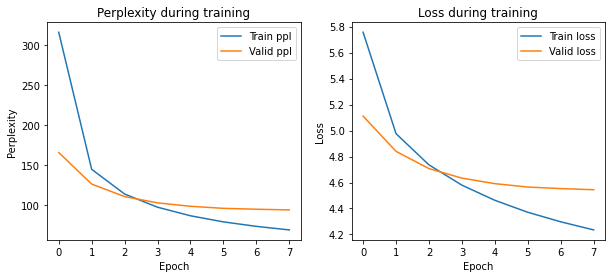

In [ ]:
import matplotlib.pyplot as plt
import numpy

epochs = numpy.array(list(range(len(plot_cache))))
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(epochs, [2**(i[0]/numpy.log(2)) for i in plot_cache], label='Train ppl')
axs[0].plot(epochs, [2**(i[1]/numpy.log(2)) for i in plot_cache], label='Valid ppl')
axs[0].legend()
axs[0].set_title('Perplexity during training')
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Perplexity")
print("Best perplexity: %.2f" % min([2**(i[1]/numpy.log(2)) for i in plot_cache]))

axs[1].plot(epochs, [i[0] for i in plot_cache], label='Train loss')
axs[1].plot(epochs, [i[1] for i in plot_cache], label='Valid loss')
axs[1].legend()
axs[1].set_title('Loss during training')
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")

plt.show()

## 3. Inference

### Conditional probability queries

We can query different probabilities:

$\large p(\underbrace{y_t}_{\text{token}}\mid\underbrace{y_{<t}}_{\text{prefix}})$

And sort by the highest probability next-tokens:

$\large \texttt{sort}(p(\,\cdot\mid\underbrace{y_{<t}}_{\text{prefix}}))$

In [ ]:
def get_top_token_given_prefix(prefix, top=10):
    inp = tokenizer.encode(prefix).ids
    with torch.no_grad():
        model.eval()
        logits = model(
            torch.tensor([inp], dtype=torch.long).to(current_device)
        )
        
    p_next_token = torch.softmax(logits[0, -1], dim=-1)

    sorted_probs, sorted_token_ids = torch.topk(p_next_token, top)

    for i in range(sorted_token_ids.size(0)):
        token = tokenizer.id_to_token(sorted_token_ids[i])
        print('p( %s%s| %s )\t= %.5f' % 
              (token, 
               '\t' if len(token) >= 5 else '\t\t',
               prefix, 
               sorted_probs[i])
        )

get_top_token_given_prefix('<bos>hello, how are')
print()
get_top_token_given_prefix('<bos>i went to the')
print()
get_top_token_given_prefix('<bos>the warrior drew his')

p( Ġyou		| <bos>hello, how are )	= 0.83546
p( Ġwe		| <bos>hello, how are )	= 0.05014
p( Ġthey	| <bos>hello, how are )	= 0.02444
p( Ġi		| <bos>hello, how are )	= 0.01972
p( Ġthe		| <bos>hello, how are )	= 0.01914
p( Ġit		| <bos>hello, how are )	= 0.00513
p( Ġthere	| <bos>hello, how are )	= 0.00488
p( Ġyour	| <bos>hello, how are )	= 0.00392
p( Ġhe		| <bos>hello, how are )	= 0.00379
p( Ġya		| <bos>hello, how are )	= 0.00272

p( Ġbathroom	| <bos>i went to the )	= 0.04249
p( Ġdoor	| <bos>i went to the )	= 0.03200
p( Ġconclusion	| <bos>i went to the )	= 0.02791
p( Ġkitchen	| <bos>i went to the )	= 0.02516
p( Ġhospital	| <bos>i went to the )	= 0.01667
p( Ġfront	| <bos>i went to the )	= 0.01628
p( Ġstudy	| <bos>i went to the )	= 0.01531
p( Ġhouse	| <bos>i went to the )	= 0.01430
p( Ġroom	| <bos>i went to the )	= 0.01401
p( Ġcar		| <bos>i went to the )	= 0.01282

p( Ġsword	| <bos>the warrior drew his )	= 0.08655
p( Ġhead	| <bos>the warrior drew his )	= 0.05682
p( Ġhand	| <bos>the warrior drew h

### Ancestral sampling

We can generate sentences by recursively sampling from the model's conditional distributions:

#### $\hat{\mathbf{y}}=(\hat{y}_1,\ldots,\hat{y}_T)$, where
#### $\quad\hat{y}_t\sim p_{\theta}(\,\cdot\mid\hat{y}_{<t}).$

In pseudocode,


            context = [<bos>]
            until <eos> is generated:
                wt ~ p(wt | context)
                context += [wt]
                
                
Here, the `~` symbol stands for sampling from a categorical distribution. 

In [ ]:
import torch

def sample(model, prefix, num_samples, temperature=1.0, max_len=20):
    inp = torch.tensor([
        tokenizer.encode(prefix).ids
    ], dtype=torch.long).to(current_device).repeat([num_samples, 1])

    sampled = [[] for _ in range(num_samples)]
    done = torch.tensor([False for _ in range(num_samples)])
    hidden = None
    
    with torch.no_grad():
        model.eval()
        for t in range(max_len):
            logits, hidden = step(model, inp, hidden)
            logits_ = (logits[:, -1, :] / temperature)
            inp = logits_.softmax(-1).multinomial(1)            
            for i in range(num_samples):
                tok_id = inp[i, 0].item()
                if tok_id == tokenizer.token_to_id('<eos>') and not done[i]:
                    done[i] = True
                    sampled[i].append(tok_id)
                elif not done[i]:
                    sampled[i].append(tok_id)
                else:
                    pass
            if done.sum() == num_samples:
                break
        
    return sampled

def step(rnn, token_ids, hidden):
    embeddings = rnn.lookup(token_ids)
    output, hidden = rnn.rnn(embeddings, hidden)
    logits = rnn.projection(output) 
    return logits, hidden


idx = np.random.randint(0, len(valid))
prefix = ['<bos>'] + tokenizer.decode(valid[idx]).split()[:15]
prefix = ' '.join(prefix)

# prefix = '<bos> the warrior drew his sword'
# prefix = '<bos> hello, how are'

print("%s\n" % prefix)
for temp in [1.0, 0.5, 0.1]:
    print("=== Temperature %.2f" % temp)
    samples = sample(model, prefix, 5, temperature=temp)
    for s in samples:
        print(tokenizer.decode(s))
        print()
    print()
    
print("=== ground-truth")
print(' '.join(tokenizer.decode(valid[idx]).split()[15:]))

<bos> she maintained a doubtful look but was prevented from arguing further by her mother ,

=== Temperature 1.00
 and god she thought . but there was nothing she could think of . try , i concill myself

 but her heart was like an inch before unsiting her . strangely neil , suddenly , gently kissed her

 sure travel it eluded me . what a reason i spoke differently , she would never see the future .

 and launched each other into the ropes as if to step his bones busy into her palm . she unleashed

 but they could not quite make their way along the short floor to defend key facilities and guards pushing the


=== Temperature 0.50
 and she was still in the same room . she was not the best person , but that was the

 and then , in her turn , was his only option . when she got closer to the door ,

 who was powerless to see the girl . she was a tall woman with a high-eyed teenager ,

 but when she was about to leave , she slowed her head into the air . she was a very

 but she didnt want t

## II. Transformer language model

### High-Level View

We can view the Transformer encoder as mapping a sequence to a sequence of vectors.

<img src="https://nyu.box.com/shared/static/o9dtlvbyedlpnij5upxqarxvcf0b6ip5" alt="Drawing" style="width: 35%;"/>

Let's step through the key ideas of how this mapping is designed, and discuss some of its resulting properties.

### Key Idea 1: Position Embeddings

Unlike RNNs which can learn positional information via the hidden state over time, the Transformer has no notion of time.

Thus we encode inputs with **position** as well as **token** embeddings:

<img src="https://nyu.box.com/shared/static/xg41bq62ojwer6sudeb41vjrfw8ggj3z" alt="Drawing" style="width: 15%;"/>

In [ ]:
input_sequence = ['<bos>', 'A', 'B', 'C', '<eos>']

max_len = 10

vocab = {'<bos>': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, '<eos>': 5}

dim = 8

token_embed = nn.Embedding(len(vocab), embedding_dim=dim)
position_embed = nn.Embedding(max_len, embedding_dim=dim)

In [ ]:
input_vector = torch.tensor([vocab[x] for x in input_sequence]).unsqueeze(1)

input_embeddings = token_embed(input_vector) + position_embed(torch.arange(len(input_vector)).unsqueeze(1))
input_embeddings.size()

torch.Size([5, 1, 8])

**Warning!!** The pytorch `nn.Transformer` classes accept input as `Length x Batch x Dim`

#### Key Idea 2: Modularity
The Transformer (encoder) is composed of a stack of **N identical layers**.

<img src="https://nyu.box.com/shared/static/v9d0tv7ykab7bne2ikdio16abnqd4qxu.png" alt="Drawing" style="width: 35%;"/>

In [ ]:
import torch.nn as nn
nn.TransformerEncoder?

#### The `forward` passes the input through the N layers, then normalizes it:

**Warning!!** The forward function accepts input as `Length x Batch x Dim`

In [ ]:
nn.TransformerEncoder.forward??

In [ ]:
encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=2, dim_feedforward=64, dropout=0.1)

encoder = nn.TransformerEncoder(encoder_layer, num_layers=4)

In [ ]:
outputs = encoder(input_embeddings)

print("input size: \t%s" % str(tuple(input_embeddings.shape)))
print("output size:\t%s" % str(tuple(outputs.shape)))
outputs

input size: 	(5, 1, 8)
output size:	(5, 1, 8)


tensor([[[ 0.8368,  0.6825,  0.5096, -1.5999, -0.8918,  1.2843, -1.1957,
           0.3743]],

        [[ 1.7790, -0.2611,  0.4446,  0.4188, -0.1651,  0.1295, -2.0670,
          -0.2787]],

        [[ 0.6286,  0.3166,  0.2832, -0.9679, -0.4894,  1.8465, -1.6834,
           0.0658]],

        [[ 1.3074, -1.0796, -0.2036,  0.8334, -0.3907, -1.5301, -0.2839,
           1.3471]],

        [[ 1.9578, -0.5658,  0.6559, -0.2056, -0.6889,  0.0820, -1.6497,
           0.4143]]], grad_fn=<NativeLayerNormBackward>)

#### Each layer has two parts, **self-attention** and a feed-forward transformation:

<img src="https://nyu.box.com/shared/static/mo6v8wllwqpiygpn99l0zgm48zlu6uig.png" alt="Drawing" style="width: 65%;"/>

In [ ]:
# nn.TransformerEncoderLayer??

In [ ]:
# nn.TransformerEncoderLayer.forward??

### Key Idea 3: Self-Attention

In the RNN, the hidden state contains information about previous tokens.
The Transformer instead performs **attention** over all inputs at a given layer. *Attention* computes an output vector by taking a weighted sum of input vectors. The weights are *attention weights*. The Transformer uses **scaled dot-product attention**.
<!-- #### $$a=\text{attention}(q,K,V)=V\text{softmax}\left(\frac{K^\top q}{\sqrt{d_k}}\right)\in \mathbb{R}^{d_v}$$

#### $$A=\text{attention}(Q,K,V)=V\text{softmax}\left(\frac{K^\top Q}{\sqrt{d_k}}\right)\mathbb{R}^{d_v\times T}$$ -->

*Multi-head attention* refers to applying several of these operations in parallel.

#### *Key Property*: Each output vector of a layer $n$ can using information from **all** inputs to the layer $n$.

Thus each **final output vector** can incorporate information from **all input words**.

In [ ]:
attn = nn.MultiheadAttention(dim, 2, dropout=0.0)

attn_outputs, attn_weights = attn.forward(query=outputs, key=outputs, value=outputs)

print("input shape: %s" % (str(tuple(outputs.size()))))
print("output shape: %s" % (str(tuple(attn_outputs.size()))))
print(outputs)

print("\nattn weights shape: %s" % (str(tuple(attn_weights.size()))))
print(attn_weights)

input shape: (5, 1, 8)
output shape: (5, 1, 8)
tensor([[[ 0.8368,  0.6825,  0.5096, -1.5999, -0.8918,  1.2843, -1.1957,
           0.3743]],

        [[ 1.7790, -0.2611,  0.4446,  0.4188, -0.1651,  0.1295, -2.0670,
          -0.2787]],

        [[ 0.6286,  0.3166,  0.2832, -0.9679, -0.4894,  1.8465, -1.6834,
           0.0658]],

        [[ 1.3074, -1.0796, -0.2036,  0.8334, -0.3907, -1.5301, -0.2839,
           1.3471]],

        [[ 1.9578, -0.5658,  0.6559, -0.2056, -0.6889,  0.0820, -1.6497,
           0.4143]]], grad_fn=<NativeLayerNormBackward>)

attn weights shape: (1, 5, 5)
tensor([[[0.2122, 0.1771, 0.1861, 0.2110, 0.2137],
         [0.1964, 0.2016, 0.2077, 0.1670, 0.2272],
         [0.2020, 0.1908, 0.1945, 0.2012, 0.2115],
         [0.1949, 0.1995, 0.1936, 0.2072, 0.2049],
         [0.1988, 0.1926, 0.1967, 0.1833, 0.2285]]], grad_fn=<DivBackward0>)


To prevent information flow to future tokens, we use **masking**.

In [ ]:
def _mask(size):
    mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

_mask(input_embeddings.size(0))

tensor([[0., -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0.]])

#### Putting it all together:

In [ ]:
import torch.nn as nn

class TransformerLanguageModel(nn.Module):
    def __init__(
      self, num_embeddings, d_model, nhead, max_len, 
      dropout, num_layers, padding_idx
    ):
        super().__init__()
        
        self.token_embed = nn.Embedding(
            num_embeddings=num_embeddings, 
            embedding_dim=d_model, 
            padding_idx=padding_idx
        )
        self.position_embed = nn.Embedding(
            num_embeddings=max_len, 
            embedding_dim=d_model
        )
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dim_feedforward=d_model, 
            dropout=dropout
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer, 
            num_layers=num_layers
        )
        self.projection = nn.Linear(
            d_model,
            num_embeddings
        )

    def _mask(self, size):
        mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
        
    def features(self, token_indices):
        mask = self._mask(token_indices.size(0)).to(token_indices.device)
        positions = torch.arange(
            len(token_indices), 
            device=token_indices.device
        ).unsqueeze(1)
        x = self.token_embed(token_indices) + self.position_embed(positions)
        x = self.encoder(x, mask=mask)
        return x
    
    def forward(self, token_indices):
        x = self.features(token_indices)
        x = self.projection(x)
        return x

In [ ]:
load_pretrained = True

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data.dataloader import DataLoader
from utils import LMTokenDataset

token_limit = 4096

train_ds = LMTokenDataset(train, tokenizer.token_to_id('<pad>'), token_limit)
valid_ds = LMTokenDataset(valid, tokenizer.token_to_id('<pad>'), token_limit)

dataloaders = {}
current_device = 'cuda'
for split, dataset in [('train', train_ds), ('valid', valid_ds)]:
    dataloaders[split] = DataLoader(
        dataset, 
        batch_size=1, 
        shuffle=True, 
        collate_fn=LMTokenDataset.collate  
    )

if load_pretrained:
    model, options, transformer_plot_cache = utils.load(
        os.path.join(save_dir, 'transformer_lm.pt'),
        current_device,
        TransformerLanguageModel
    )
    print("Loaded pretrained model.")
else:
    d_model = 512
    num_layers = 3
    dropout = 0.1

    options = {
        'num_embeddings': tokenizer.get_vocab_size(),
        'padding_idx': tokenizer.token_to_id('<pad>'),
        'd_model': d_model,
        'num_layers': num_layers,
        'dropout': dropout,
        'nhead': 4,
        'max_len': 500
    }    

    model = TransformerLanguageModel(options)
    model.cuda()

    model = model.to(current_device)

    criterion = nn.CrossEntropyLoss(
        ignore_index=tokenizer.token_to_id('<pad>'), 
        reduction='sum'
    )

    model_parameters = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.Adam(model_parameters, lr=0.001)

    scheduler = StepLR(optimizer, step_size=1, gamma=0.5)

size 130950 (0 discarded) (max len 210) (1536 batches)
size 14550 (0 discarded) (max len 164) (173 batches)
Loaded pretrained model.


In [ ]:
from tqdm import tqdm
import os
load_pretrained = True
import numpy

pad = tokenizer.token_to_id('<pad>')
if not load_pretrained:
    best_val_loss = 1e10
    early_stop = 0
    transformer_plot_cache = []
    for epoch_number in range(100):
        avg_loss = 0
        model.train()

        # === Train
        train_loss_cache = 0
        train_non_pad_tokens_cache = 0
        iterator = enumerate(dataloaders['train'])
        for i, (inp, target) in iterator:
            inp = inp.to(current_device).T.contiguous()
            target = target.to(current_device).T.contiguous()
            logits = model(inp)

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            train_loss_cache += loss.item()  # still sum here

            non_pad_tokens = target.view(-1).ne(pad).sum().item()            
            train_non_pad_tokens_cache += non_pad_tokens

            loss /= non_pad_tokens 
            optimizer.zero_grad()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

            optimizer.step()

            if i > 0 and i % 100 == 0:
                avg_loss = train_loss_cache / train_non_pad_tokens_cache
                print('%d | %d loss %.4f' % (
                    epoch_number, i, avg_loss
                ))
                train_log_cache = []
        
        if epoch_number > 0 and epoch_number%5 == 0:
            scheduler.step()

        # === Validation
        valid_loss_cache = 0
        valid_non_pad_tokens_cache = 0
        model.eval()
        with torch.no_grad():
            for i, (inp, target) in enumerate(dataloaders['valid']):
                inp = inp.to(current_device).T.contiguous()
                target = target.to(current_device).T.contiguous()
                logits = model(inp)

                loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
                valid_loss_cache += loss.item()  # still sum here
                non_pad_tokens = target.view(-1).ne(pad).sum().item()

                valid_non_pad_tokens_cache += non_pad_tokens

            avg_val_loss = valid_loss_cache / valid_non_pad_tokens_cache
            print('=== Epoch %d complete. Val loss %.5f (%.2f ppl) [%.3E lr]' % (
                epoch_number, 
                avg_val_loss, 
                2**(avg_val_loss/numpy.log(2)),
                optimizer.param_groups[0]['lr']
            ))

            if avg_val_loss < best_val_loss:
                print("\tBest loss achieved (%.5f) (%.2f ppl)" % (
                    avg_val_loss, 2**(avg_val_loss/numpy.log(2))
                ))
                best_val_loss = avg_val_loss
                early_stop = 0
                # Saving the model
                torch.save({
                    'options': options,
                    'loss_cache': transformer_plot_cache,
                    'model_dict': model.state_dict()
                }, os.path.join(save_dir, 'transformer_lm.pt'))
            else:
                early_stop += 1
                scheduler.step()
                print("\t New lr %.3E" % (
                    optimizer.param_groups[0]['lr']
                ))
            
            if early_stop == 5:
                print("-- Stopping early.")
                break
            print()
            

        transformer_plot_cache.append((avg_loss, avg_val_loss))


Best validation perplexity (recurrent): 94.11
Best validation perplexity (transformer): 88.21


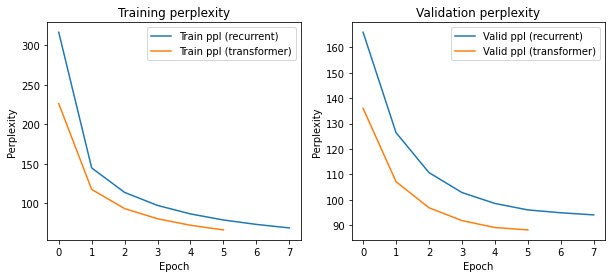

In [ ]:
import matplotlib.pyplot as plt
import numpy

epochs = numpy.array(list(range(len(plot_cache))))
transformer_epochs = numpy.array(list(range(len(transformer_plot_cache))))

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(epochs, [2**(i[0]/numpy.log(2)) for i in plot_cache], label='Train ppl (recurrent)')
axs[0].plot(transformer_epochs, [2**(i[0]/numpy.log(2)) for i in transformer_plot_cache], label='Train ppl (transformer)')
axs[0].legend()
axs[0].set_title('Training perplexity')
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Perplexity")

axs[1].plot(epochs, [2**(i[1]/numpy.log(2)) for i in plot_cache], label='Valid ppl (recurrent)')
axs[1].plot(transformer_epochs, [2**(i[1]/numpy.log(2)) for i in transformer_plot_cache], label='Valid ppl (transformer)')
axs[1].legend()
axs[1].set_title('Validation perplexity')
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Perplexity")
print("Best validation perplexity (recurrent): %.2f" % min([2**(i[1]/numpy.log(2)) for i in plot_cache]))
print("Best validation perplexity (transformer): %.2f" % min([2**(i[1]/numpy.log(2)) for i in transformer_plot_cache]))

plt.show()

In [ ]:
def get_top_token_given_prefix(prefix, top=10):
    inp = tokenizer.encode(prefix).ids
    with torch.no_grad():
        model.eval()
        logits = model(
            torch.tensor([inp], dtype=torch.long).to(current_device).T
        )
        
    p_next_token = torch.softmax(logits[-1, 0], dim=-1)
    sorted_probs, sorted_token_ids = torch.topk(p_next_token, top)

    for i in range(sorted_token_ids.size(0)):
        token = tokenizer.id_to_token(sorted_token_ids[i])
        print('p( %s%s| %s )\t= %.5f' % 
              (token, 
               '\t' if len(token) >= 5 else '\t\t',
               prefix, 
               sorted_probs[i])
        )

get_top_token_given_prefix('<bos>hello, how are')
print()
get_top_token_given_prefix('<bos>i went to the')
print()
get_top_token_given_prefix('<bos>the warrior drew his')

p( Ġyou		| <bos>hello, how are )	= 0.64624
p( Ġwe		| <bos>hello, how are )	= 0.24931
p( Ġthey	| <bos>hello, how are )	= 0.04354
p( Ġi		| <bos>hello, how are )	= 0.02501
p( Ġyour	| <bos>hello, how are )	= 0.00869
p( Ġthe		| <bos>hello, how are )	= 0.00464
p( Ġthese	| <bos>hello, how are )	= 0.00303
p( Ġit		| <bos>hello, how are )	= 0.00179
p( Ġhe		| <bos>hello, how are )	= 0.00112
p( Ġthere	| <bos>hello, how are )	= 0.00111

p( Ġbathroom	| <bos>i went to the )	= 0.04291
p( Ġdoor	| <bos>i went to the )	= 0.03579
p( Ġkitchen	| <bos>i went to the )	= 0.02953
p( Ġfront	| <bos>i went to the )	= 0.02055
p( Ġstudy	| <bos>i went to the )	= 0.01864
p( Ġwindow	| <bos>i went to the )	= 0.01603
p( Ġbedroom	| <bos>i went to the )	= 0.01544
p( Ġfuneral	| <bos>i went to the )	= 0.01373
p( Ġtemple	| <bos>i went to the )	= 0.01344
p( Ġreception	| <bos>i went to the )	= 0.01271

p( Ġsword	| <bos>the warrior drew his )	= 0.50123
p( Ġattention	| <bos>the warrior drew his )	= 0.05778
p( Ġgaze	| <bos>the war

## Large-scale Language Modeling: GPT-2

The language model above is relatively small in terms of the number of parameters, and is trained on a small dataset.

A recent trend in research is to train **large-scale language models** on **large amounts of data**, resulting in improved language modeling and generation ability. 

A representative example is **GPT-2** [[paper](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)], [[blog](https://openai.com/blog/better-language-models/)]. We can easily **use a pre-trained version to generate text**:

#### Load the model and tokenizer

In [ ]:
import torch
from transformers import (
    GPT2LMHeadModel,
    GPT2Tokenizer
)

device = torch.device('cpu') if not torch.cuda.is_available() else torch.device('cuda:0')

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.to(device);

#### Generate (Sampling)

In [ ]:
prefix = 'My favorite food is'

max_length = 100
num_samples = 5

inp = torch.tensor([tokenizer.encode(prefix)], device=device).repeat(num_samples, 1)

out = model.generate(
    input_ids=inp,
    do_sample=True,
    max_length=max_length,
    temperature=1.0
)

for i in range(num_samples):
    sample = tokenizer.decode(out[i])
    print(sample)
    print('---------------------------------------------------\n\n')

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


My favorite food is really the chicken broth. I think you could say this a recipe for a long time.

1 cup ketchup

1/2 cup canola oil

1 teaspoon minced red pepper

1/2 teaspoon ground cumin

2 tablespoons garlic powder

1/2 teaspoon kosher salt

1/2 teaspoon turmeric

1/4 teaspoon red chili flakes

1 cup cooked chick peas


Instructions:

1)
---------------------------------------------------


My favorite food is right over here and when I'm outside I love the flavors of a hot dog and steak. Just love being inside at one of my favorite places in Austin. I didn't have enough of it so I opted for this one at my local BBQ. It's so tender. I don't have to worry about the meat though too bad I'm not a huge fan like when I think about it. I was craving more crispy meat that could be made into a thin but crispy piece
---------------------------------------------------


My favorite food is to try to get your meal on it. The "soup" style is one of our favorite flavors in all of Greek food."
